In [1]:


# importar modulos completos
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# importar comandos especificos
from scipy.linalg import inv  # comando de inversion de matrices
from scipy.linalg import toeplitz  # comando generacion matrices Toeplitz
from scipy.io import wavfile
from scipy.signal import lfilter, freqz

plt.close("all")

"""
1. Calcular la SNR obtenida sin cancelación del eco.
La SNR entre una señal x(n) y una distorsión aditiva de la misma d(n) se computa como:
SNR = 10log10 sum(x2(n))/sum(d2(n))
En nuestro caso, la señal x(n) sería la señal local que se quiere transmitir y la distorsión
es d(n) = y(n)x(n), donde y(n) es la señal que se transmite finalmente (en este caso sin
cancelación, y(n) corresponde a signal).

"""

# Importamos las señales
f_local, local = wavfile.read("data/local.wav")
local = local.astype(np.float32)  # x(n)
f_remota, remota = wavfile.read("data/remota.wav")  # d(n) = y(n)-x(n)
remota = remota.astype(np.float32)
f_signal, signal = wavfile.read("data/signal.wav")  # y(n)
signal = signal.astype(np.float32)

# Distorsión como d(n) = y(n) - x(n)
distorsion = signal - local

# SNR en dB
snr = 10 * np.log10(np.sum(local**2) / np.sum(distorsion**2))
print(snr)


7.7387595


In [8]:
u_vec = [0.0005, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128]
p_vec = [2, 3, 4, 5, 6, 7]


DTD_instant = 2150
errors_DTD = np.empty((len(u_vec), len(p_vec)), dtype=object)
w_filters_DTD = np.empty_like(errors_DTD)
SNRs_DTD = np.empty_like(errors_DTD)


for i, u in enumerate(u_vec):
    for j, p in enumerate(p_vec):
        w_filter_DTD = np.zeros(p)
        buffer_DTD = np.zeros(p)
        error_DTD = np.zeros(len(remota))
        w_hist_DTD = np.zeros((len(remota), p))

        for k in range(len(remota)):
            # actualiza buffer
            buffer_DTD[1:] = buffer_DTD[:-1]  # Al asignar, desplazas cada valor un paso hacia la derecha
            buffer_DTD[0] = remota[k]  # introduce una nueva muestra

            y_DTD = w_filter_DTD.T @ buffer_DTD
            error_DTD[k] = local[k] - y_DTD
            energia_DTD = np.dot(buffer_DTD, buffer_DTD) + 1e-8

            if k < DTD_instant:
                # Solo actualiza mientras no haya DTD

                w_filter_DTD += (2 * u * error_DTD[k] / energia_DTD) * buffer_DTD
                w_hist_DTD[k, :] = w_filter_DTD  # ← aquí rellenas w_hist
            else:
                # A partir de 2150, filtro fijo (no actualizas)
                w_hist_DTD[k, :] = w_filter_DTD  # explícito, aunque no necesario

        # al salir del bucle en k, guardo:
        errors_DTD[i][j] = error_DTD
        w_filters_DTD[i][j] = w_hist_DTD  # o w_filter si solo te importa el final
        SNRs_DTD[i][j] = 10 * np.log10(
            np.sum(local**2) / np.sum((local - error_DTD) ** 2)
        )


# 1) Encuentro el índice de la SNR máxima (sin DTD)
i_opt_DTD, j_opt_DTD = np.unravel_index(np.argmax(SNRs_DTD), SNRs_DTD.shape)
u_opt_DTD = u_vec[i_opt_DTD]
p_opt_DTD = p_vec[j_opt_DTD]
SNR_opt_DTD = SNRs_DTD[i_opt_DTD, j_opt_DTD]


# 2) Recupero el historial de coeficientes para esa combinación
#    w_coefs[j_opt][i_opt] es un array de forma (N, p_opt)
w_opt_DTD = np.array(w_filters_DTD[i_opt_DTD][j_opt_DTD])

Obtenemos una SNR para el cancelador de eco con DTD 56.77 dB
El orden del filtro óptimo es p = 7 y μ = 0.0005


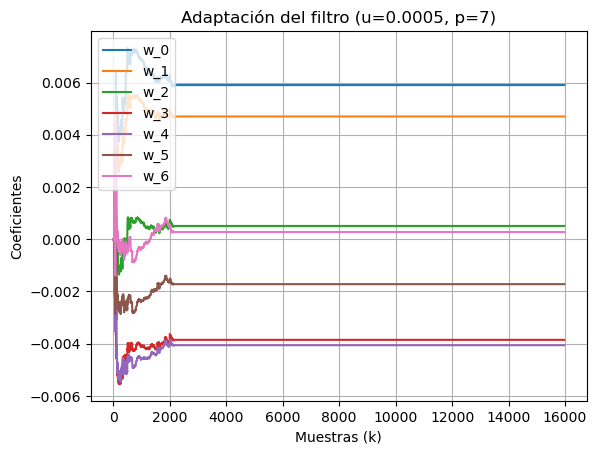

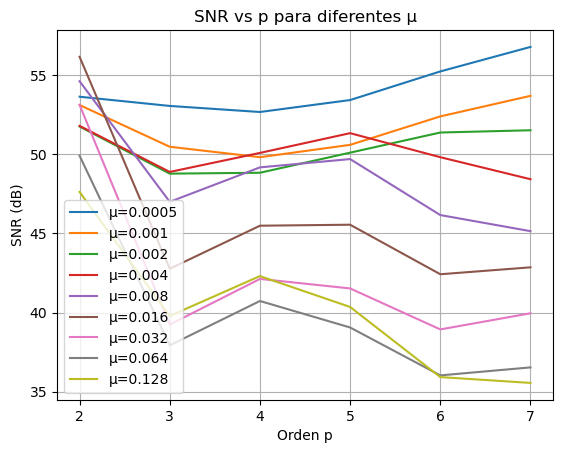

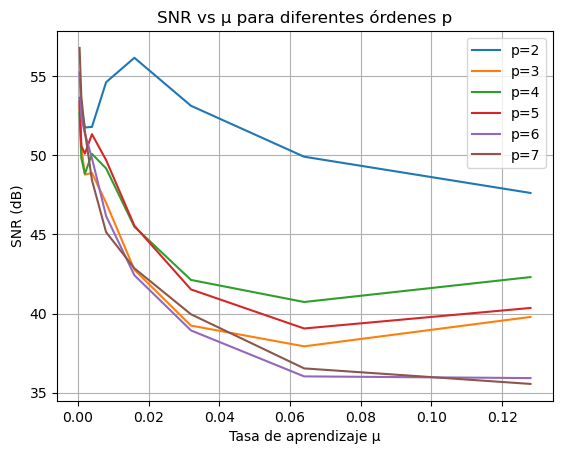

In [7]:

# 3) Imprimo resultados
print(
    "Obtenemos una SNR para el cancelador de eco con DTD {:.2f} dB".format(SNR_opt_DTD)
)
print("El orden del filtro óptimo es p = {} y μ = {}".format(p_opt_DTD, u_opt_DTD))

# 4) Representación de la adaptación de coeficientes
plt.figure()
plt.ylabel("Coeficientes")
plt.xlabel("Muestras (k)")
plt.title(f"Adaptación del filtro (u={u_opt_DTD}, p={p_opt_DTD})")
for idx in range(p_opt_DTD):
    plt.plot(w_opt_DTD[:, idx], label=f"w_{idx}")
plt.legend()
plt.grid()


# Gráfica 1: SNR vs p para cada μ
plt.figure()
for i, u in enumerate(u_vec):
    plt.plot(p_vec, SNRs_DTD[i, :], label=f"μ={u}")
plt.xlabel("Orden p")
plt.ylabel("SNR (dB)")
plt.title("SNR vs p para diferentes μ")
plt.legend()
plt.grid()

# Gráfica 2: SNR vs μ para cada p
plt.figure()
for j, p in enumerate(p_vec):
    plt.plot(u_vec, SNRs_DTD[:, j], label=f"p={p}")
plt.xlabel("Tasa de aprendizaje μ")
plt.ylabel("SNR (dB)")
plt.title("SNR vs μ para diferentes órdenes p")
plt.legend()
plt.grid()
plt.show()


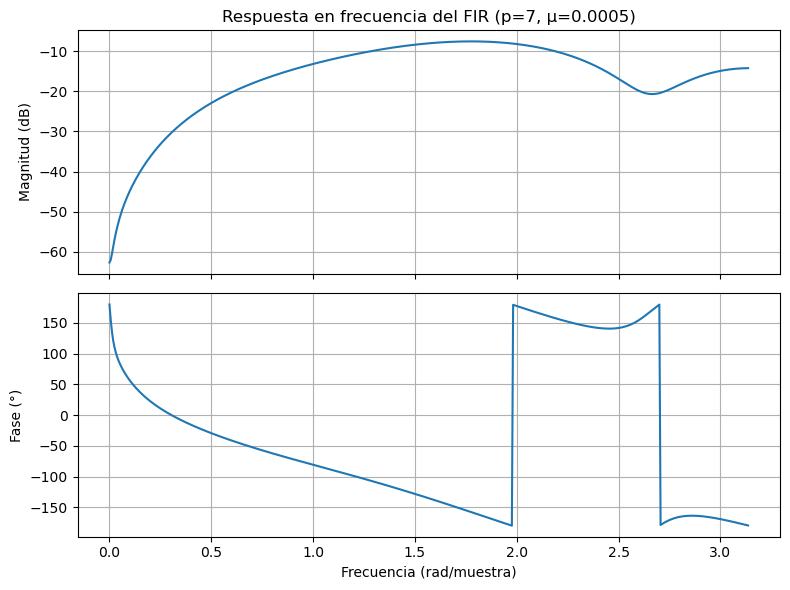

In [5]:

# 1) Extraer los coeficientes del filtro en la muestra 2150
w_filter_2150 = w_filter_DTD


# 1) Respuesta en frecuencia
w_freq, h = freqz(b=w_filter_2150, a=1)
H_dB = 20 * np.log10(np.abs(h) + 1e-12)
phase_deg = np.angle(h, deg=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax1.plot(w_freq, H_dB)
ax1.set_ylabel("Magnitud (dB)")
ax1.set_title(f"Respuesta en frecuencia del FIR (p={p_opt_DTD}, μ={u_opt_DTD:.4f})")
ax1.grid(True)

ax2.plot(w_freq, phase_deg)
ax2.set_ylabel("Fase (°)")
ax2.set_xlabel("Frecuencia (rad/muestra)")
ax2.grid(True)

plt.tight_layout()
plt.show()
